In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.transforms as T
import matplotlib
import matplotlib.pyplot as plt

# Define custom Dataset

In [3]:
import cv2 as cv

def video_to_tensor(path, frames_limit=0):
    cap = cv.VideoCapture(path)
    
    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    num_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    
    frames = torch.FloatTensor(3, num_frames, height, width)
    
    for i in range(num_frames):# while(cap.isOpened()):
        #cap.set(cv.CAP_PROP_POS_FRAMES, i) # to set the video position
        ret, frame = cap.read()
        if ret == False:
            break
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        frame = torch.from_numpy(frame)
        frame = frame.permute(2, 0, 1) # (H x W x C) to (C x H x W)
        frames[:, i, :, :] = frame.float()
    
    cap.release()
    
    if frames_limit == 0: return frames / 255
    
    ##############################
    # Limit the number of frames #
    ##############################
    
    multiplier = num_frames / frames_limit
    selected_frames = [0] * frames_limit
    for i in range(frames_limit):
        selected_frames[i] = (int)(i * multiplier)
    
    limited_frames = torch.FloatTensor(3, frames_limit, height, width)
    
    for i, elem in enumerate(selected_frames):
        limited_frames[:, i, :, :] = frames[:, elem, :, :]
    
    return limited_frames / 255

In [4]:
# Define Dataset class
class WLASLDataset(Dataset):
    """Class to load WLASL videos and labels."""
    
    def __init__(self, csv_file, transforms=None, frames_limit=0):
        """
        Args:
            csv_file (string): The path to the csv_file
            transforms: The transforms to apply to the videos
            frames_limit (int): The number of frames that every video will have
                                0 when I don't need to limit it
        """
        self.dataframe = pd.read_csv(csv_file)
        self.classes = self.dataframe.label.unique().tolist()
        self.transforms = transforms
        self.frames_limit = frames_limit

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        
        video = video_to_tensor(path = self.dataframe.iloc[index].path,
                                frames_limit = self.frames_limit)
        if self.transforms:
            video = self.transforms(video)
        
        label = self.dataframe.iloc[index].label
        label = self.classes.index(label)
        
        return video, label

In [5]:
# Load dataset
dataset = WLASLDataset("./wlasl5.csv", frames_limit=32)

print('elements:',len(dataset))
print('shapes:',dataset[0][0].size())
print('classes:',dataset.classes)

elements: 157
shapes: torch.Size([3, 32, 256, 256])
classes: ['BEFORE', 'BOOK', 'CHAIR', 'COMPUTER', 'DRINK']


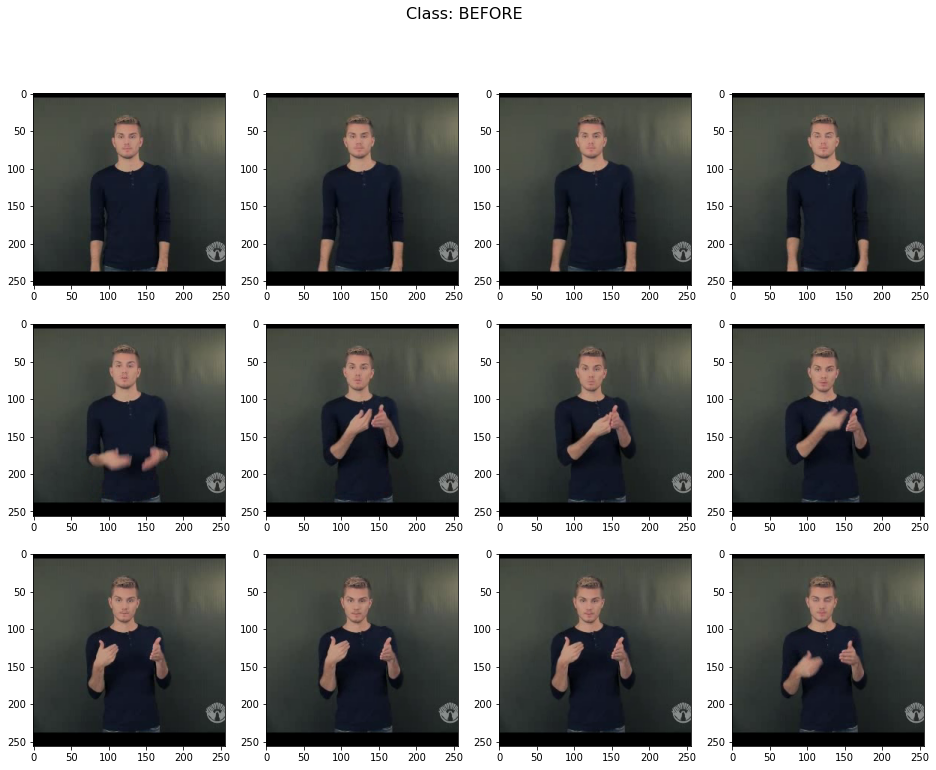

In [6]:
# Show example
video, label = dataset[1]
label = dataset.classes[label]
n_frames = video.size()[1]

n_row = 3
n_col = 4
r = n_row*n_col
multiplier = (int)(n_frames / r)

plt.figure(figsize=(16,n_row*4))
plt.suptitle('Class: '+label, fontsize=16)
for i in range(r):
    plt.subplot(n_row,n_col,i+1)
    frame = T.ToPILImage()(video[:, i*multiplier, :, :])
    plt.imshow(frame)
plt.show()

# Define train, validation and data loaders

In [7]:
# Create training validation
#train_size = int(len(dataset) * 0.15)
#train_size = len(dataset) - val_size
train_size = 128
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(128, 29)

In [8]:
# Create data loaders to load the data in batches
batch_size = 8

train_loader = DataLoader(dataset=train_ds,
                          batch_size=batch_size,
                          shuffle=True, num_workers=4, pin_memory=True)

val_loader = DataLoader(dataset=val_ds,
                        batch_size=batch_size*2, num_workers=4, pin_memory=True)

#for videos, labels in train_loader:
#    print(videos.size(), labels)

torch.Size([8, 3, 32, 256, 256]) tensor([1, 4, 3, 3, 2, 1, 4, 4])
torch.Size([8, 3, 32, 256, 256]) tensor([4, 0, 1, 4, 3, 0, 4, 1])
torch.Size([8, 3, 32, 256, 256]) tensor([1, 3, 4, 1, 4, 2, 3, 1])
torch.Size([8, 3, 32, 256, 256]) tensor([4, 1, 1, 3, 3, 2, 2, 4])
torch.Size([8, 3, 32, 256, 256]) tensor([3, 2, 3, 1, 2, 3, 1, 3])
torch.Size([8, 3, 32, 256, 256]) tensor([0, 1, 1, 1, 4, 3, 2, 4])
torch.Size([8, 3, 32, 256, 256]) tensor([1, 2, 2, 3, 0, 0, 0, 0])
torch.Size([8, 3, 32, 256, 256]) tensor([3, 1, 1, 0, 1, 1, 3, 4])
torch.Size([8, 3, 32, 256, 256]) tensor([2, 3, 3, 0, 0, 4, 3, 0])
torch.Size([8, 3, 32, 256, 256]) tensor([0, 4, 4, 4, 1, 2, 4, 1])
torch.Size([8, 3, 32, 256, 256]) tensor([0, 1, 2, 0, 2, 1, 0, 0])
torch.Size([8, 3, 32, 256, 256]) tensor([0, 3, 2, 0, 3, 0, 1, 4])
torch.Size([8, 3, 32, 256, 256]) tensor([3, 1, 0, 4, 4, 3, 1, 3])
torch.Size([8, 3, 32, 256, 256]) tensor([3, 0, 3, 0, 4, 4, 3, 2])
torch.Size([8, 3, 32, 256, 256]) tensor([4, 2, 1, 3, 4, 3, 2, 1])
torch.Size

In [9]:
#  use gpu if available
%run to_device
device = get_default_device()

# Move data loaders to the appropriate device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

<Figure size 432x288 with 0 Axes>

# Define model

In [41]:
%run my_models

def conv3d_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm3d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool3d((2, 4, 4)))
    return nn.Sequential(*layers)

class ResNet3d(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # 3, 32, 256, 256
        self.conv1 = conv3d_block(in_channels, 8) # -> 8, 32, 256, 256
        self.conv2 = conv3d_block(8, 16, pool=True) # -> 16, 16, 64, 64
        self.res1 = nn.Sequential(conv3d_block(16, 16),
                                  conv3d_block(16, 16))
        
        self.conv3 = conv3d_block(16, 32, pool=True) # -> 32, 8, 16, 16
        self.conv4 = conv3d_block(32, 64, pool=True) # -> 64, 4, 4, 4
        self.res2 = nn.Sequential(conv3d_block(64, 64),
                                  conv3d_block(64, 64))
        
        self.classifier = nn.Sequential(nn.MaxPool3d(2), # -> 64, 2, 2, 2
                                        nn.Flatten(), # -> 64*2*2*2
                                        nn.Dropout(0.2),
                                        nn.Linear(64*2*2*2, num_classes)) # -> 5

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [33]:
class CNNModel(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        #super(CNNModel, self).__init__()
        super().__init__()
        # 3, 32, 256, 256
        self.conv_layer1 = self._conv_layer_set(in_channels, 16) # -> 16, 16, 64, 64
        self.conv_layer2 = self._conv_layer_set(16, 32) # -> 32, 8, 16, 16
        self.fc1 = nn.Linear(32*8*16*16, 128) # -> 128
        self.relu = nn.LeakyReLU()
        self.batch=nn.BatchNorm1d(128)
        self.drop=nn.Dropout(p=0.15)
        self.fc2 = nn.Linear(128, num_classes)  # -> 5
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(3, 3, 3), padding=1),
        nn.LeakyReLU(),
        nn.MaxPool3d((2, 4, 4)),
        )
        return conv_layer

    def forward(self, x):
        # Set 1
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.batch(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

# Train model

In [49]:
# Create a model and load it to the specified device, either gpu or cpu
model = ResNet3d(3,5)
to_device(model, device)

ResNet3d(
  (conv1): Sequential(
    (0): Conv3d(3, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=(2, 4, 4), stride=(2, 4, 4), padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_runn

In [50]:
%run train
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.26442307233810425, 'val_loss': 1.6109859943389893}]

<Figure size 432x288 with 0 Axes>

In [51]:
epochs = 40
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam
#init_lr = 0.001

history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=optimizer)

Epoch [0], val_loss: 1.5748, val_acc: 0.2644
Epoch [1], val_loss: 1.8465, val_acc: 0.1779
Epoch [2], val_loss: 2.2685, val_acc: 0.3630
Epoch [3], val_loss: 1.9528, val_acc: 0.2861
Epoch [4], val_loss: 2.8353, val_acc: 0.3870
Epoch [5], val_loss: 23.0660, val_acc: 0.0769
Epoch [6], val_loss: 10.4250, val_acc: 0.0769
Epoch [7], val_loss: 6.5113, val_acc: 0.0769
Epoch [8], val_loss: 2.9962, val_acc: 0.0938
Epoch [9], val_loss: 1.9902, val_acc: 0.3870
Epoch [10], val_loss: 4.5913, val_acc: 0.3245
Epoch [11], val_loss: 1.4289, val_acc: 0.4014
Epoch [12], val_loss: 2.4319, val_acc: 0.5120
Epoch [13], val_loss: 1.3749, val_acc: 0.6274
Epoch [14], val_loss: 0.9934, val_acc: 0.5264
Epoch [15], val_loss: 1.1340, val_acc: 0.5192
Epoch [16], val_loss: 1.0012, val_acc: 0.6587
Epoch [17], val_loss: 0.9806, val_acc: 0.6899
Epoch [18], val_loss: 1.0027, val_acc: 0.5192
Epoch [19], val_loss: 0.9373, val_acc: 0.5889
Epoch [20], val_loss: 1.7645, val_acc: 0.4736
Epoch [21], val_loss: 1.3050, val_acc: 0.5

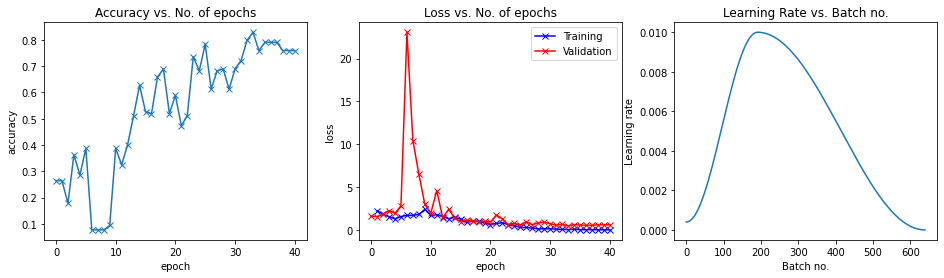

In [52]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plot_accuracies(history)
plt.subplot(1,3,2)
plot_losses(history)
plt.subplot(1,3,3)
plot_lrs(history)
plt.show()

# MNIST AUTOENCODER

In [54]:
transform = T.ToTensor()

mnist_data = torchvision.datasets.MNIST(root='~/torch_datasets', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(
    dataset=mnist_data,
    batch_size=64,
    shuffle=True,
    num_workers=4, pin_memory=True
)

test_dataset = torchvision.datasets.MNIST(root='~/torch_datasets', train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)


Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw




Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw




Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw




Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [55]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [57]:
class Autoencoder_Linear(nn.Module):
  def __init__(self):
    super().__init__()
    # N, 784
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 128), # -> N, 128
        nn.ReLU(),
        nn.Linear(128, 64), # -> N, 64
        nn.ReLU(),
        nn.Linear(64, 12), # -> N, 12
        nn.ReLU(),
        nn.Linear(12, 3) # -> N, 3
    )

    # N, 3
    self.decoder = nn.Sequential(
        nn.Linear(3, 12), # -> N, 12
        nn.ReLU(),
        nn.Linear(12, 64), # -> N, 64
        nn.ReLU(),
        nn.Linear(64, 128), # -> N, 128
        nn.ReLU(),
        nn.Linear(128, 28*28), # -> N, 784
        nn.Sigmoid() # To get values between 0 and 1 (our original range)
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Note: T.ToTensor() -> [0, 1] -> nn.Sigmoid
# Note: T.Compose([T.ToTensor(), T.Normalize(0.5, 0.5)]) -> [-1, 1] -> nn.Tanh

In [58]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    # N, 1, 28, 28
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
        nn.ReLU(),
        nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
    )

     # N, 64, 1, 1
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # -> N, 16, 14, 14
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # -> N, 1, 28, 28
        nn.Sigmoid() # To get values between 0 and 1 (our original range)
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Note: T.ToTensor() -> [0, 1] -> nn.Sigmoid
# Note: T.Compose([T.ToTensor(), T.Normalize(0.5, 0.5)]) -> [-1, 1] -> nn.Tanh
# nn.MaxPool2d -> nn.MaxUnPool2d

In [60]:
#  use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder().to(device)

# mean-squared error loss
criterion = nn.MSELoss()

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [61]:
num_epochs = 20
outputs = []
for epoch in range(num_epochs):
    loss = 0
    for (img, _) in data_loader:
        # load data to the active device
        img = img.to(device)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        # compute reconstructions
        recon = model(img)
        # compute training reconstruction loss
        train_loss = criterion(recon, img)
        # compute accumulated gradients
        train_loss.backward()
        # perform parameter update based on current gradients
        optimizer.step()
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    # compute the epoch training loss
    loss = loss / len(data_loader)
    # display the epoch training loss
    print(f'epoch : {epoch+1}/{num_epochs}, loss = {loss:.6f}')
    outputs.append((epoch,img,recon))

epoch : 1/20, loss = 0.031444
epoch : 2/20, loss = 0.006748
epoch : 3/20, loss = 0.004669
epoch : 4/20, loss = 0.003789
epoch : 5/20, loss = 0.003342
epoch : 6/20, loss = 0.003115
epoch : 7/20, loss = 0.002981
epoch : 8/20, loss = 0.002891
epoch : 9/20, loss = 0.002831
epoch : 10/20, loss = 0.002789
epoch : 11/20, loss = 0.002746
epoch : 12/20, loss = 0.002724
epoch : 13/20, loss = 0.002697
epoch : 14/20, loss = 0.002676
epoch : 15/20, loss = 0.002660
epoch : 16/20, loss = 0.002650
epoch : 17/20, loss = 0.002632
epoch : 18/20, loss = 0.002623
epoch : 19/20, loss = 0.002620
epoch : 20/20, loss = 0.002613


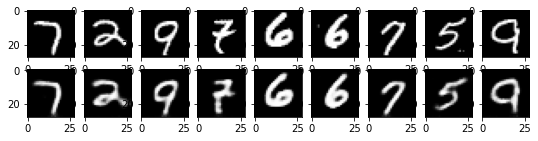

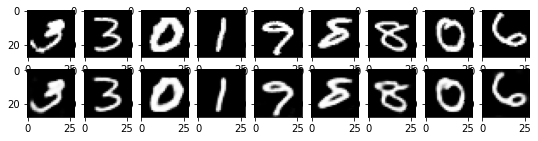

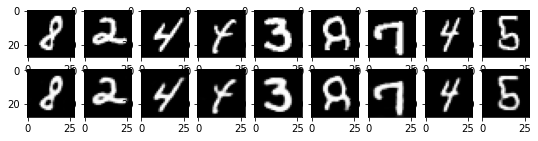

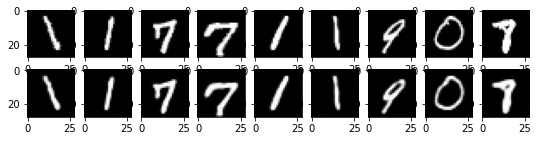

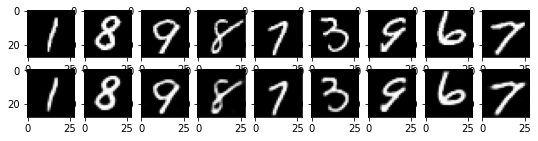

In [62]:
for k in range(0, num_epochs, 4):
  plt.figure(figsize=(9,2))
  plt.gray()
  imgs = outputs[k][1].detach().cpu().numpy()
  recon = outputs[k][2].detach().cpu().numpy()
  for i, item in enumerate(imgs):
    if i >= 9: break
    plt.subplot(2, 9, i+1) # row_length +i +1
    #item = item.reshape(-1, 28, 28) # item: 1, 28, 28 # when using cnn autoencoder, remove this
    plt.imshow(item[0])
  
  for i, item in enumerate(recon):
    if i >= 9: break
    plt.subplot(2, 9, 9+i+1) # row_length +i +1
    #item = item.reshape(-1, 28, 28) # item: 1, 28, 28 # when using cnn autoencoder, remove this
    plt.imshow(item[0])